In [53]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

I thought that test [pooling](https://www.cnn.com/2020/06/26/politics/anthony-fauci-testing-coronavirus-task-force/index.html) was a cool and clever idea after Fauci said that the task force was seriously considering it.
To my understanding test pooling is mixing in multiple samples and then running them through the assay machine together.  The advantage of this would be that if everyone in the pool was negative the machine would read negative and you would get an *n* time speedup through the machine.  In Fauci's breifing he said machines could handle up to 10 samples at a time.
If a test came up positive you would then one at a time go through the members of the pool and retest them.
With a low enough background rate and a correct size pool we can test more people with the same number of assay machines.
However it would come at the cost of 2x the number of swabs per person -- or requiring people to come back to give a second swab after the initial test came back positive.

I wanted to get an upper bound for how much a strategy like this could help so I simulated it out.

In [49]:
def wilson_cc_confidence(hits, num_samples, alpha=0.05):
    """
    :param hits: number Number of actives
    :param num_samples: number Number of total samples
    :param alpha: 1 - confidence interval size
    :return: (confidence_low, confidence_high)
    get confidence limits for proportion
    using wilson score method w/ cont correction
    i.e. Method 4 in Newcombe [1];
    """

    n = num_samples
    p = hits / n
    q = 1. - p
    z = stats.norm.isf(alpha / 2.)
    z2 = z**2
    denom = 2 * (n + z2)
    num = 2. * n * p + z2 - 1. - z * np.sqrt(z2 - 2 - 1. / n + 4 * p *
                                             (n * q + 1))
    ci_l = num / denom
    num = 2. * n * p + z2 + 1. + z * np.sqrt(z2 + 2 - 1. / n + 4 * p *
                                             (n * q - 1))
    ci_u = num / denom
    if p == 0:
        ci_l = 0.
    elif p == 1:
        ci_u = 1.
    return ci_l, ci_u

def bootstrap_confidence(hits, samples):
    hit_bs = []
    l = [1] * hits + [0] * (samples -  hits)
    for i in range(10_000):
        l1 = np.random.choice(l, len(l))
        hit_bs.append(np.sum(l1)/samples)
    return np.percentile(hit_bs,5), np.percentile(hit_bs, 95)

In [46]:
class Runner(object):
    def __init__(self, background_rate):
        self.background_rate = background_rate

    def run_many_trials(self, batch_size, num_samples=10_000):
        results = []
        for i in range(num_samples):
            results.append(self.run_trial(batch_size))
        avg_tests = np.mean(results)
        tests_per_person = avg_tests / batch_size
        return tests_per_person
        
        
    def create_infections(self, batch_size):
        v = np.random.random(size=batch_size)
        v = v < self.background_rate
        return v
    
    def run_trial(self, batch_size):
        people = self.create_infections(batch_size)
        if sum(people) == 0:
            return 1
        return 1 + batch_size
    
    def run(self):
        results = []
        for batch_size in range(1,10):
            results.append(self.run_many_trials(batch_size))
        return min(results), results

In [47]:
runner = Runner(0.03)
ttp, plt_data = runner.run()

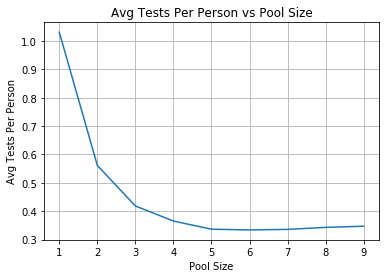

In [48]:
plt.grid()
plt.title("Avg Tests Per Person vs Pool Size")
plt.xlabel('Pool Size')
plt.ylabel("Avg Tests Per Person")
plt.plot(range(1,10), plt_data)

Important assumptions for this analysis --
1. 3% of the country has covid right now

This is a number that I kinda made up.  Later we are going to get a couple of different ways that we can estimate this.

2. We know nothing about an individual that would increase or decrease this background rate -- (the samples are i.i.d)

In an ideal pooling strategy we have an oracle who knows apriori whether an individual has covid or not.  If we know this we can send positive patients through one at a time and then negative patients through 10 at a time.  As the background rate decreases we want to increase pool size.  For all analysis here we assume that the patient outcomes are independent and identically distributed random variables.  We know this is not true.  We can easily condition these probabilities on a questionaire, to get better results.

With these settings we should set a batch size of 6 to only require ~1/3 of a test per person.  That is a pretty big speedup for relatively little work!  Also because of (2) that this assumes i.i.d this is an upper bound estimate of the testing efficiency speed up.

### Is 3% Testing Positive today (06/29/2020) a good guess?

The NBA is returning to soon, and as a preliminary step tested all of the players who will play in Orlando.  In the tests 16 or 302 players tested positive.  This is a good sample in the fact that these players were selected not because they had symptoms but instead they were choosen independent of showing symptoms.  There are a number of reasons that the rate of NBA players might not be representative of the country as a whole but lets ignore that for now and take a 95% confidence interval of the true rate of NBA players assuming i.i.d and use that as bounds for the U.S.

Here we will use the [Wilson Score Interval With Continuity Correction](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#:~:text=a%20score%20test.-,Wilson%20score%20interval%20with%20continuity%20correction,probability%2C%20with%20the%20nominal%20value.) and a [bootstrap confidence interval](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Deriving_confidence_intervals_from_the_bootstrap_distribution).

In [55]:
print(f"Wilson CC Confidence Interval {wilson_cc_confidence(16,302)}")
print(f"Bootstrap Confidence Interval {bootstrap_confidence(16,302)}")

Wilson CC Confidence Interval (0.031596180714027575, 0.08630723905083608)
Bootstrap Confidence Interval (0.033112582781456956, 0.076158940397351)


So using this data we can estimate that the background rate is ~3%-8.7%.  This is more dire than my initial gut estimate.  What happens to our testing efficiency in this regime?

In [58]:
background_rates = np.linspace(0.03, 0.087, 20)
efficiencies = []
for rate in background_rates.tolist():
    runner = Runner(rate)
    efficiencies.append(runner.run()[0])

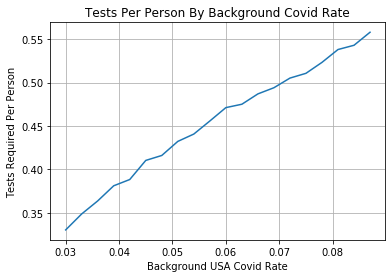

In [59]:
plt.grid()
plt.title("Tests Per Person By Background Covid Rate")
plt.xlabel("Background USA Covid Rate")
plt.ylabel("Tests Required Per Person")
plt.plot(background_rates, efficiencies)
plt.savefig("tests_per_person_by_covid_rate.png")

## Testing Efficiency Not Nearly As Good In This Regime

So as the background rate of covid goes up testing efficiency via pooling decreases quickly.  Reminder this is with the assumption that every person has an equal probability of testing positive for covid.  In order for us to make this strategy useful with background rates at this level we need to have higher fidelity guesses per patient of their likelihood of testing positive for covid.  With that information we can run pools with all individuals closwer to 0 which can raise efficiency of the process overall.  In summary I was a bit dissapointed by the back of the envelope efficiencies gained from this process, when I heard about it on the news my gut assumption is it could lead to 5x test efficiency improvement.  This is still possible -- just not with a naive implementation randomly putting people from all across the country into a testing pool.